# 19 Accounts Suspensions - Analysis
We have previously queried the status of all the accounts we have. 
They can be "found" (if still existing in Twitter), "not found" (if the owners deleted the account), "suspended" (if Twitter ban the account).

In this notebook we analyse the users that have been suspended.
- where are they from?
- where them in no-vax communities?
- when have they been suspended?
- did they spread misinformation?
- did the suspension affect misinformation spread?

In [341]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import repeat
from glob import glob
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

In [300]:
folder = "/data/public/jlenti/multilang-vax/EuropeAmerica_RTCO"
folder_data = "/data/public/jlenti/m*/EuropeAmerica*"
folder_RTURLS = "/data/public/jlenti/multilang-vax/RT_edgelists_with_urls"

#list of all countries (size ordered)
countries = ["US", "BR", "AR", "GB", "ES", "MX", "FR", "CA", "TR", "VE", "AU", "CO", "IT", "CL", "DE",
             "PT", "IE", "PY", "EC", "RU", "UY", "NZ", "PL", "NL", "PE", "CU", "PA", "GR"]
#sorted by language
lang_sort = ["US", "IE", "GB", "CA", "NZ", "AU", "FR", "IT", "PL", "NL", "DE", "RU", "TR", 
             "BR", "PT", "GR", "AR", "ES", "MX","VE", "CO", "CL",
             "PY", "EC", "UY", "PE", "CU", "PA"]
#named periods
periods = ["period" + str(u + 1) for u in range(4)]

country_lang = pd.DataFrame([u.split("/")[-1].split("_")[:2] 
                             for u in sorted(glob("/".join([folder_data, "*1", "*RT*mod*"])))], 
                            columns = ["country", "lang"]).set_index("country")

#list of novax communities
#i transform it into a dataframe with columns (id, country, period, community)
#novax_com = pd.read_csv("/home/jlenti/Files/novax_communities_thres066_0402.csv", index_col = 0).apply(lambda x: pd.Series([x[0]] + x[0].split("_"), index = ["com", "country", "period", "community"]), axis = 1)
novax_com = pd.read_csv("/home/jlenti/Files/novax_communities_9tot_antivax_0902.csv", index_col = 0).apply(lambda x: pd.Series([x[0]] + x[0].split("_"), index = ["com", "country", "period", "community"]), axis = 1)

#list of neutral domains (url shorteners, twitter.com, facebook.com)
neutrals = pd.read_csv("/home/jlenti/Files/neutral_domains_1309.txt")["0"].tolist()
#list of low-credible domains
blacklist = pd.read_csv("/home/jlenti/Files/merged_blacklist_1309.txt")["0"].tolist()
blacklist.extend(pd.read_csv( '/home/jlenti/Files/lemonde_blacklist_2709.txt')["domain"].tolist())
blacklist.extend(pd.read_csv('/home/jlenti/Files/greek_blacklist_1009.txt')["0"].tolist())
#domains associated to youtube
youtube_domains = ["youtube.com", "youtu.be"]

In [5]:
sorted(glob("/".join([folder, "*", "*status*"])))[0]

'/data/public/jlenti/multilang-vax/EuropeAmerica_RTCO/period1/AR_es_period1_user_status.csv'

In [290]:
#functions to read the data about edgelist, and community assignement for the users of the given country/period
def read_data(period, country, obj, network = "RT"):
    l = sorted(glob("/".join([folder_data, period, "*".join([country, obj, network,""])])))
    if len(l) > 1:
        print(l)
    D = pd.read_csv(sorted(glob("/".join([folder_data, period, "*".join([country, network, obj, ""])])))[0])
    return D
#functions to read the data about the rteweet edgelist in the given country/period for retweets containing a url
def read_data_urls(period, country):
    lang = country_lang.loc[country, "lang"]
    l = sorted(glob("/data/public/jlenti/multilang-vax/RT_edgelists_with_urls/{0}/{1}/*".format(lang, period)))
    if len(l) > 1:
        print(l)
    D = pd.read_csv(l[0]) \
    .query("country_RT == @country")
    return D

In [6]:
#dataframe with all the account status of the users considered
accounts_status = pd.concat([pd.read_csv(file) \
                             .assign(lang = file.split("_")[2], country = file.split("_")[1][-2:]) 
                             for file in sorted(glob("/".join([folder, "*", "*status*"])))])


In [8]:
accounts_status.head()

,user_screen_name,status,lang,country
0,AdopcionesQ,found,es,AR
1,Aleneyrubi,found,es,AR
2,AngeloDonatoni1,found,es,AR
3,BumperCrop1,found,es,AR
4,DamianFresolone,found,es,AR


### Account Status per Network
For each country each period count the account status for all the users in the RT network and save it in a dataframe.

#### Example

In [326]:
country = "IT"
period = "period1"
users = read_data(period, country, "com", "RT")["user"].tolist()

In [327]:
count_status = pd.Series([period, country], index = ["period", "country"]) \
.append(accounts_status.query("user_screen_name in @users")["status"].value_counts())
count_status

period       period1
country           IT
found          13436
not found        860
suspended        467
dtype: object

#### All countries

In [324]:
count_status_countries = []
for country in countries:
    for period in periods:
        users = read_data(period, country, "com", "RT")["user"].tolist()
        count_status_countries.append(pd.Series([period, country], index = ["period", "country"]) \
                                      .append(accounts_status.query("user_screen_name in @users")["status"].value_counts()))

In [325]:
status_countries = pd.concat(count_status_countries, axis = 1).transpose().set_index(["country", "period"]).fillna(0)
status_countries.head()

found  suspended  not found
country period                               
US      period1   25835       6216       2662
        period2  167093      31312      19861
        period3  302043      43685      34242
        period4  368737      19651      21316
BR      period1   72884       3103      21208

#### Proportion account status per nework

In [63]:
status_countries.apply(lambda x: x / x.sum(), axis = 1).sort_values("found").head(10)

found  suspended  not found
country period                                 
US      period1  0.744246   0.179068   0.076686
BR      period1  0.749874   0.031926   0.218201
US      period2  0.765548   0.143458   0.090994
EC      period3  0.765871   0.077154   0.156974
        period2  0.790722   0.082543   0.126736
NZ      period2  0.794198   0.135495   0.070307
US      period3  0.794913   0.114970   0.090118
NZ      period3  0.823028   0.119264   0.057708
TR      period1  0.840603   0.040370   0.119028
RU      period1  0.847096   0.093072   0.059832

#### Proportion account status per period
Plot in a single figure the proportion of found, not found, suspended accounts, per period.

In [67]:
status_countries.groupby("period").sum().apply(lambda x: x / x.sum(), axis = 1).sort_values("found")

,found,suspended,not found
period,,,
period1,0.863654,0.036992,0.099353
period2,0.880996,0.042035,0.076970
period3,0.888443,0.038263,0.073294
period4,0.916513,0.022205,0.061282


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

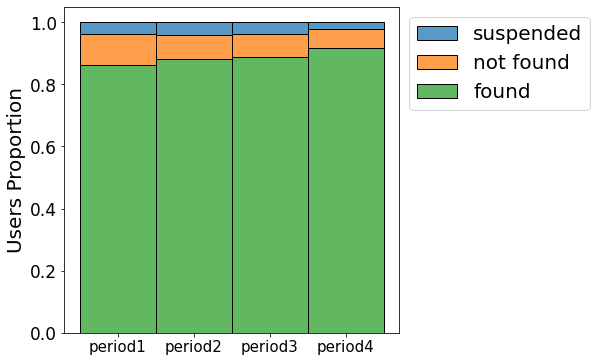

In [115]:
fig, axes = plt.subplots(1,1, figsize = [6, 6])

df = status_countries.groupby("period").sum().apply(lambda x: x / x.sum(), axis = 1) \
.stack().reset_index().rename(columns = {"level_1": "status", 0: "proportion"})
sns.histplot(data = df, x = "period", weights = "proportion", hue = "status", multiple = "stack", 
             hue_order = ["suspended", "not found", "found"])

axes.set_ylabel("Users Proportion", fontsize = 20)
axes.set_xlabel("", fontsize = 20)

plt.rc("legend", fontsize = 20)
legend = axes.get_legend()
legend.set_title("")
legend.set_bbox_to_anchor((1, 1))

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 17)

Proportion of suspended/not found accounts is decreasing, because the older ones had more time to be suspended

#### Proportion account status per country
Same plot by country, instead of by period.

In [66]:
status_countries.groupby("country").sum().apply(lambda x: x / x.sum(), axis = 1).sort_values("found")

,found,suspended,not found
country,,,
EC,0.827609,0.052185,0.120206
US,0.828375,0.096738,0.074887
BR,0.853200,0.027667,0.119133
TR,0.854464,0.037326,0.108211
NZ,0.858360,0.077017,0.064622
PT,0.880109,0.008661,0.111230
RU,0.889842,0.056044,0.054115
FR,0.891936,0.018700,0.089363
VE,0.901960,0.063806,0.034234


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

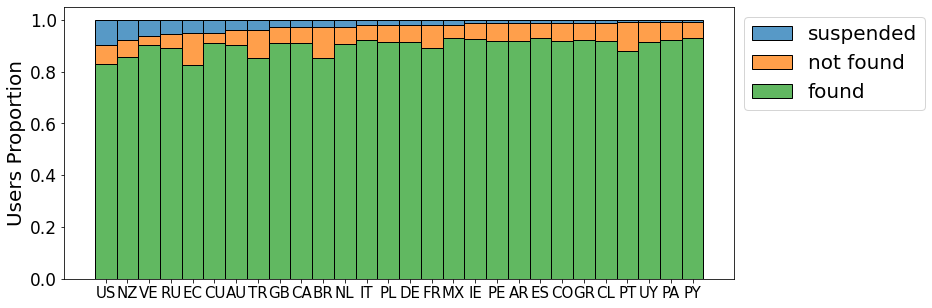

In [108]:
fig, axes = plt.subplots(1,1, figsize = [12, 5])

df = status_countries.groupby("country").sum().apply(lambda x: x / x.sum(), axis = 1) \
.sort_values("suspended", ascending = False).stack().reset_index().rename(columns = {"level_1": "status", 0: "proportion"})
sns.histplot(data = df, x = "country", weights = "proportion", hue = "status", multiple = "stack", 
             hue_order = ["suspended", "not found", "found"])

axes.set_ylabel("Users Proportion", fontsize = 20)
axes.set_xlabel("", fontsize = 20)

plt.rc("legend", fontsize = 20)
legend = axes.get_legend()
legend.set_title("")
legend.set_bbox_to_anchor((1, 1))

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 17)

In [74]:
status_countries.groupby("country").sum().apply(lambda x: x / x.sum(), axis = 1) \
.sort_values("found").stack().reset_index().rename(columns = {"level_1": "status", 0: "proportion"})

,country,status,proportion
0,EC,found,0.827609
1,EC,suspended,0.052185
2,EC,not found,0.120206
3,US,found,0.828375
4,US,suspended,0.096738
...,...,...,...
79,MX,suspended,0.018533
80,MX,not found,0.051317
81,PY,found,0.931670
82,PY,suspended,0.006383


### Suspended Accounts and NoVax Communities
Let us compare the proportion of suspended accounts in novax communities and rest of the networks.

In [123]:
#transform the dataframe containing novax communities [(country, period, community), (country, period, community)]
#in a dataframe [(country, period, (list of communities))]
novax_coms_list = novax_com.assign(period = lambda x: ["period" + str(u) for u in x["period"]]).groupby(["country", "period"]).apply(lambda x: list(x["community"]))

In [328]:
novax_status_count = []
#for each period having a novax community I extract users and their labelling
for _, (country, period, coms) in novax_coms_list.reset_index().iterrows():
    #dataframe with users and communities
    #and label 'novax' the ones in a novax community
    users = read_data(period, country, "com", "RT") \
    .assign(novax = lambda x: x["community"].isin([int(u) for u in coms]))
    #merge information about users communities with their status, to compare the membership to a novax community
    #with their suspension
    #and count the found/not found/suspended users per period, per country, per label
    novax_status_count.append(users.merge(accounts_status, left_on = "user",
                                          right_on = "user_screen_name")[["novax", "status"]].value_counts() \
                              .reset_index().rename(columns = {0: "users"}).assign(period = period, country = country))

In [329]:
novax_status = pd.concat(novax_status_count)
novax_status.head()

,novax,status,users,period,country
0,False,found,9903,period1,AU
1,False,not found,483,period1,AU
2,True,found,271,period1,AU
3,False,suspended,156,period1,AU
4,True,suspended,127,period1,AU


In [331]:
#sum all the found/not found/suspended users in the same period and check the proportion
df = novax_status.groupby(["period", "novax", "status"]).sum() \
.unstack().apply(lambda x: x / x.sum(), axis = 1)
df

users                    
status            found not found suspended
period  novax                              
period1 False  0.930619  0.052513  0.016868
        True   0.661585  0.104233  0.234182
period2 False  0.919791  0.065198  0.015011
        True   0.757335  0.108961  0.133704
period3 False  0.923330  0.063232  0.013437
        True   0.765656  0.109707  0.124638
period4 False  0.942626  0.049633  0.007741
        True   0.864490  0.080129  0.055381

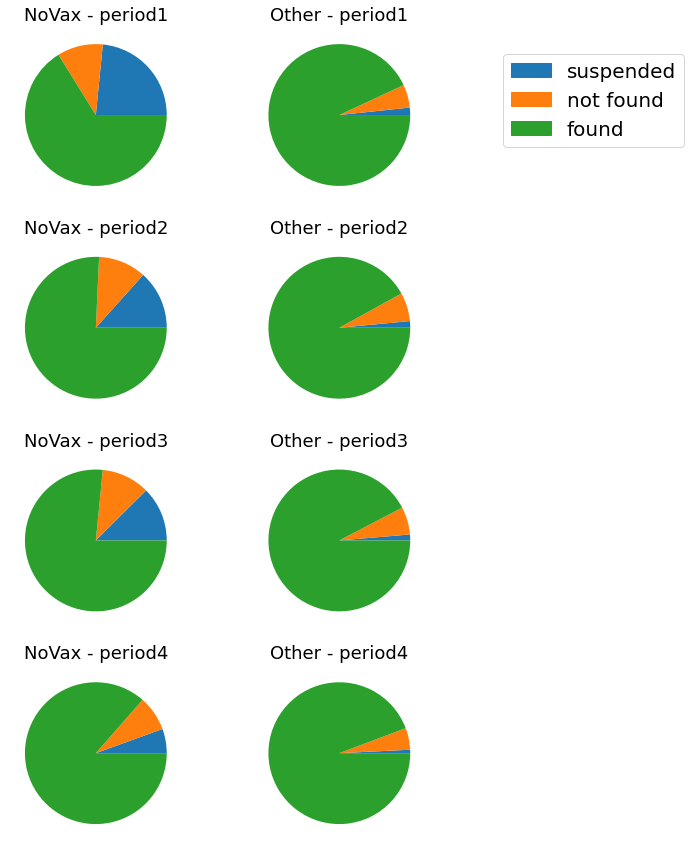

In [344]:
fig, axes = plt.subplots(4, 2, figsize = [8, 15])

#int(k) / 2 for k in range(8) is [0,0,1,1,2,2,3,3] is the y coordinate for the plot
#k % 2 == 0 for k in range(8) is [True, False, True, False, True, False, True, False] is the x coordinate
for k in range(8):
    ax, period, novax = axes.ravel()[k], periods[int(k / 2)], k % 2 == 0
    #create a piechart considering the given period/label 
    ax.pie(x = df.loc[(period, novax), "users"][["suspended", "not found", "found"]])
    if novax:
        side = "NoVax"
    else:
        side = "Other"
    ax.set_title(side + " - " + period, fontsize = 18)
    #define the colors (the same as before)
    cols = sns.color_palette("tab10")[:3]
    #define the patches for the legend
    l1 = mpatches.Patch(color = cols[0], label = "suspended")
    l2 = mpatches.Patch(color = cols[1], label = "not found")
    l3 = mpatches.Patch(color = cols[2], label = "found")
    #define manually the legend and put it outside the plots
    plt.legend(handles=[l1, l2, l3], bbox_to_anchor = (2.5, 4.5))


## When they have been suspended?
For each suspended account that we have I check when did he posted a tweet or he has been retweeted for last time in our dataset.

In [ ]:
#pandas Series of all suspended accounts
suspended_accounts_mar_df = pd.concat([pd.read_csv(file).assign(lang = file.split("_")[2], country = file.split("_")[1][-2:]) 
                                for file in sorted(glob("/".join([folder, "*", "*status*"])))]) \
.query("status == 'suspended'")
#corresponding set to deduplicate them
suspended_accounts_mar = set(suspended_accounts_mar_df["user_screen_name"].tolist())
#dictionary with keys day
#starting from last day, for each day I store all the users in suspended_accounts_mar
#and remove them from suspended_accounts_mar
#in this way, I am storing only the users that are appearing for last time
last_day_mar = {u: set() for u in set(files_df.query("day < '20210401'")["day"])}

for _, (file, day) in files_df.query("day < '20210401'").iterrows():
    #set of users that tweeted or have been retweeted that day
    users = set(pd.read_csv(file, sep = "\t", lineterminator = "\n",
                            low_memory = False, quoting = False,
                            escapechar = None)[["user_screen_name", "RT_user_screen_name"]].stack().tolist())
    #I add at last_day_mar[day] all the users appearing that day and that have been suspended
    last_day_mar[day] = last_day_mar[day] | (users & suspended_accounts_mar)
    #remove from the set all the users that have appeared that day
    suspended_accounts_mar = suspended_accounts_mar - users

In [ ]:
#create a dataframe with columns day (that is the day extracted from file name, i.e. 2021-01-01 from 20210101filename) 
#and users, that is the list of suspended accounts that have posted their last tweet that day
suspended_users_date_mar = pd.Series(last_day_mar).reset_index().sort_values("index") \
.rename(columns = {0: "users"}).assign(number_users = lambda x: [len(u) for u in x["users"]]) \
.assign(date = lambda x: pd.to_datetime(x["index"] \
                                        .apply(lambda s: "-".join([s[:4], s[4:6], s[6:]])))) \
.replace({0 : np.nan})

In [235]:
last_tweet_country_mar = suspended_users_date_mar.explode("users") \
.merge(suspended_accounts_df.rename(columns = {"user_screen_name": "users"}))
#last_tweet_country_mar.to_csv("/home/jlenti/Files/last_tweet_suspaccounts_march_0404.csv", index = False)
last_tweet_country_mar

,index,users,number_users,date,status,lang,country
0,20191001,fikrihur1453,32.0,2019-10-01,suspended,tr,TR
1,20191001,diana_schlemin,32.0,2019-10-01,suspended,es,MX
2,20191001,calgary_spunky,32.0,2019-10-01,suspended,en,CA
3,20191001,Marianalobinho,32.0,2019-10-01,suspended,pt,BR
4,20191001,Bdglr_,32.0,2019-10-01,suspended,fr,FR
...,...,...,...,...,...,...,...
133510,20210331,Alejand26557780,7301.0,2021-03-31,suspended,es,VE
133511,20210331,Alejand26557780,7301.0,2021-03-31,suspended,es,VE
133512,20210331,Q_to_the_resQue,7301.0,2021-03-31,suspended,en,US
133513,20210331,WaltonirB,7301.0,2021-03-31,suspended,pt,BR


In [237]:
#for each country and date count the number of suspended accounts having aljust posted last that day
#to know when accounts have been suspended for each country
countries_cumsum_df_mar = last_tweet_country_mar.groupby(["date", "country"]) \
.count()["users"].unstack().fillna(0).cumsum()

In [252]:
#list of countries sorted by number of accounts suspended 
countries_susp_order_mar = countries_cumsum_df_mar.loc["2021-03-31"].sort_values(ascending = False).index
countries_susp_order_mar

Index(['US', 'VE', 'BR', 'GB', 'MX', 'FR', 'CA', 'EC', 'AR', 'TR', 'ES', 'AU',
       'CO', 'DE', 'IT', 'RU', 'CL', 'NL', 'IE', 'CU', 'NZ', 'PL', 'PT', 'PE',
       'PY', 'UY', 'PA', 'GR'],
      dtype='object', name='country')

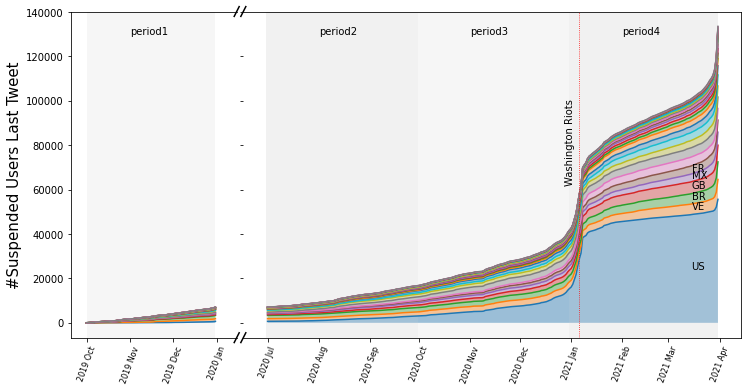

In [274]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6), sharey = True, 
                               gridspec_kw = {"width_ratios": [1, 3]})

df = countries_cumsum_df_mar.reset_index().assign(date = lambda x: [pd.to_datetime(u) for u in x["date"]]).set_index("date")
dates1 = df.loc[df.index < "2020-01-01"].index
prev_series1 = df.loc[df.index < "2020-01-01"].assign(users = 0)["users"]
dates2 = df.loc[(df.index > "2020-06-30")&(df.index < "2021-04-01")].index
prev_series2 = df.loc[(df.index > "2020-06-30")&(df.index < "2021-04-01")].assign(users = 0)["users"]

for country in countries_susp_order_mar:    
    series1 = prev_series1.add(df.loc[df.index < "2020-01-01", country], fill_value = 0)
    series2 = prev_series2.add(df.loc[(df.index > "2020-06-30")&(df.index < "2021-04-01"), country], fill_value = 0)
    ax1.plot(dates1, series1)
    ax2.plot(dates2, series2)
    ax1.fill_between(x = dates1, y1 = prev_series1, y2 = series1, alpha = 0.5)
    ax2.fill_between(x = dates2, y1 = prev_series2, y2 = series2, alpha = 0.5)
    y_countrylab = np.mean([series2[-20], prev_series2[-20]])
    if y_countrylab < 70000:
        ax2.text(pd.to_datetime("2021-03-15"), y_countrylab, country)
    prev_series1, prev_series2 = series1, series2

ax2.axvline(pd.to_datetime("2021-01-06"), color = "red", linestyle = "dotted", lw = 0.8)

ax2.text(pd.to_datetime("2020-12-28"), 63000, "Washington Riots", rotation = 90) 

#hide plot between two breaks
ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
#ax2.yaxis.set_ticks([])

height_periods = 130000
ax1.text(pd.to_datetime("2019-11-01"), height_periods, "period1") 
ax2.text(pd.to_datetime("2020-08-01"), height_periods, "period2") 
ax2.text(pd.to_datetime("2020-11-01"), height_periods, "period3") 
ax2.text(pd.to_datetime("2021-02-01"), height_periods, "period4") 
        
#ax.set_title("Last Tweets posted by Suspended Accounts", fontsize = 20)
ax1.set_ylabel("#Suspended Users Last Tweet", fontsize = 15)
#ax1.set_xlim([pd.to_datetime("2019-10-01"), pd.to_datetime("2021-03-31")])

col_plot = "lightgray"
ax1.axvspan(pd.to_datetime("2019-10-01"), pd.to_datetime("2019-12-31"), facecolor = col_plot, alpha = 0.2)
ax2.axvspan(pd.to_datetime("2020-06-30"), pd.to_datetime("2020-09-30"), facecolor = col_plot, alpha = 0.3)
ax2.axvspan(pd.to_datetime("2020-09-30"), pd.to_datetime("2020-12-31"), facecolor = col_plot, alpha = 0.2)
ax2.axvspan(pd.to_datetime("2020-12-31"), pd.to_datetime("2021-03-31"), facecolor = col_plot, alpha = 0.3)

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
labels = ax1.get_xticklabels() + ax2.get_xticklabels()

ax1.set_xlim([pd.to_datetime("2019-09-20"), pd.to_datetime("2020-01-15")])

plt.setp(labels, fontsize = 8, rotation = 70)

# Make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace = 0.02)
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform = ax1.transAxes, color = "k", clip_on = False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs) # top-left diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs) # bottom-left diagonal

kwargs.update(transform = ax2.transAxes) # switch to the bottom axes
ax2.plot((-d / 3, d / 3), (-d, +d), **kwargs) # top-right diagonal
ax2.plot((-d / 3, d / 3), (1 - d, 1 + d), **kwargs) # bottom-right diagonal
    


#### When did Donald Trump have been suspended?

In [279]:
last_tweet_country_mar.query("users == 'realDonaldTrump'")

,index,users,number_users,date,status,lang,country
64808,20210108,realDonaldTrump,3785.0,2021-01-08,suspended,en,US
64809,20210108,realDonaldTrump,3785.0,2021-01-08,suspended,en,US
64810,20210108,realDonaldTrump,3785.0,2021-01-08,suspended,en,US
64811,20210108,realDonaldTrump,3785.0,2021-01-08,suspended,en,US


#### Where are the suspended accounts from?

In [283]:
(last_tweet_country_mar.country.value_counts() / len(last_tweet_country_mar)).reset_index() \
.rename(columns = {"country": "suspended_users", "index": "country"}) \
.merge(pd.read_csv("/home/jlenti/Files/users_per_country_lang_other_nongeo.csv").groupby("country").sum().loc[countries] \
.apply(lambda x: x / x.sum()).reset_index()).assign(susp_prob = lambda x: x["suspended_users"] / x["users"]) \
.sort_values("suspended_users", ascending = False)

,country,suspended_users,users,susp_prob
0,US,0.416530,0.333698,1.248225
1,VE,0.066989,0.023423,2.859963
2,BR,0.059364,0.152972,0.388071
3,GB,0.056188,0.101108,0.555725
4,MX,0.043793,0.058247,0.751846
5,FR,0.040759,0.036091,1.129361
6,CA,0.039404,0.036240,1.087299
7,EC,0.038475,0.012346,3.116410
8,AR,0.037427,0.050719,0.737918
9,TR,0.037052,0.008941,4.144272


- **Some countries are much more likely to be suspended** (susp_prob column)
- **40% accounts are from US**

#### Before Washington Riots

In [288]:
last_tweet_country_mar[(last_tweet_country_mar["index"] < 20201222)].country.value_counts() \
.reset_index().set_index("index").apply(lambda x: x / x.sum()).head()

,country
index,
US,0.312668
EC,0.086509
VE,0.085024
BR,0.075053
GB,0.064111


#### During Washington Riots

In [287]:
last_tweet_country_mar[(last_tweet_country_mar["index"] > 20201222)&(last_tweet_country_mar["index"] < 20210113)].country.value_counts() \
.reset_index().set_index("index").apply(lambda x: x / x.sum()).head()

,country
index,
US,0.751006
CA,0.042435
GB,0.041170
AU,0.030618
FR,0.021003


The proportion of suspended accounts coming from US jumps from 31% to 77% in the days of Capitol Hill Attacks.

## Did misinformation in US decrease in period 4?

In [293]:
US_urls = pd.concat([read_data(period, "US", "", "url").query("domain not in @neutrals") \
                     .assign(LC = lambda x: x["domain"].isin(blacklist), period = period)
                     for period in periods])

In [346]:
print("Proportion of Low-Credible Domains in US")
US_urls.groupby(["period", "LC"]).count()["urls"].unstack().apply(lambda x: x / x.sum(), axis = 1)[True]

Proportion of Low-Credible Domains in US


period
period1    0.186122
period2    0.155503
period3    0.143356
period4    0.074198
Name: True, dtype: float64

It is halved after period3.

## Is misinformation in US shared by suspended accounts?

In [348]:
print("Proportion of Low-Credible Domains that have been shared by suspended accounts")
suspended_users = set(last_tweet_country_mar["users"])
US_urls.query("LC").assign(suspended = lambda x: x["user"].isin(suspended_users)).groupby(["period", "suspended"]).count()["urls"].unstack() \
.apply(lambda x: x / x.sum(), axis = 1)[True]

Proportion of Low-Credible Domains that have been shared by suspended accounts


period
period1    0.357805
period2    0.352169
period3    0.362176
period4    0.106602
Name: True, dtype: float64

It was quite high, and it was strongly reduced, telling that Twitter was suspending accounts spreading misinformation.

## Does misinformation in US come from suspended accounts?

In [301]:
#retweets containing low-credible URLs, labelled if the retweets point a suspended accounts
urls_us_edgelist = pd.concat([read_data_urls(period, "US").query("LC") \
                              .assign(period = period, suspended_RT = lambda x: x["user_RT"] \
                                      .isin(suspended_users)) for period in periods])

In [349]:
print("Proportion of Retweets containing Low-Credible Domains that come from suspended accounts")
urls_us_edgelist.groupby(["period", "suspended_RT"]).count()["urls"].unstack() \
.apply(lambda x: x / x.sum(), axis = 1)[True]

Proportion of Retweets containing Low-Credible Domains that come from suspended accounts


period
period1    0.736502
period2    0.561260
period3    0.554022
period4    0.109487
Name: True, dtype: float64

It is very high until period3. So, Twitter suspended accounts that were successfull in spreading misinformation to the rest of the network.

## Does misinformation imported by other countries from US decrease?

In [350]:
#retweets from one country to another containing urls
#'neutral' urls are the ones pointing to social networks or url shorteners
cross_urls_df = pd.read_csv("/home/jlenti/Files/cross_border_retweeted_urls_2403.csv", index_col = 0)
cross_urls_df.head()

,RT_user_screen_name,user_country_code,RT_user_country_code,urls,lang,domain,LC,neutral,period
user_screen_name,,,,,,,,,
SteeliestLlama,CoffeeShopRabbi,GB,US,https://twitter.com/NUCLEARnicole/status/11823...,da,twitter.com,False,True,period1
IntJewCon,CoffeeShopRabbi,GB,US,https://twitter.com/NUCLEARnicole/status/11823...,da,twitter.com,False,True,period1
TomVargheseJr,jennybencardino,US,CO,https://twitter.com/drianweissman/status/11832...,da,twitter.com,False,True,period1
DrIanWeissman,jennybencardino,US,CO,https://twitter.com/drianweissman/status/11832...,da,twitter.com,False,True,period1
SaludHEALTHinfo,jennybencardino,US,CO,https://twitter.com/drianweissman/status/11832...,da,twitter.com,False,True,period1


In [306]:
#filter retweets coming from US, that are not neutral, and count the proportion of low-credible
LC_cross_prop = cross_urls_df.query("(RT_user_country_code == 'US')&(~neutral)") \
.groupby(["user_country_code", "period"]).mean()["LC"].reset_index()#.unstack()

In [351]:
print("Proportion of domains from US to other countries that are low-credible")
cross_urls_df.query("(RT_user_country_code == 'US')&(~neutral)") \
.groupby(["period", "LC"]).count().unstack()["urls"].apply(lambda x: x[True] / x.sum(), axis = 1)

Proportion of domains from US to other countries that are low-credible


period
period1    0.183955
period2    0.131033
period3    0.141129
period4    0.077070
dtype: float64

The suspension of the accounts by Twitter halved the proportion of low-credible domains in the other countries.

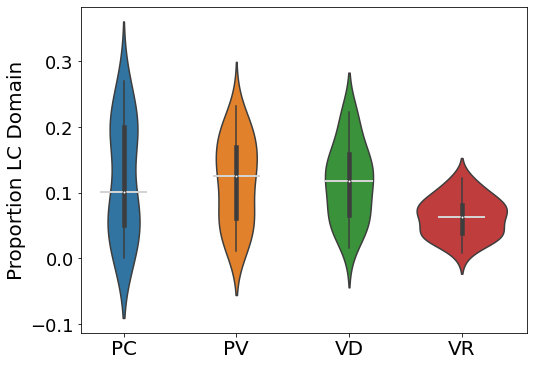

In [308]:
fig, axes = plt.subplots(1,1,figsize = [8, 6])

sns.violinplot(data = LC_cross_prop, 
               x = "period", y = "LC")

axes.set_xticklabels(["PC", "PV", "VD", "VR"], fontsize = 20)
axes.set_xlabel("")
axes.set_ylabel("Proportion LC Domain", fontsize = 20)
plt.yticks(fontsize = 18)

medians = []
for k in range(4):
    period = "period" + str(k + 1)
    median = LC_cross_prop.query("period == @period")["LC"].median()
    medians.append(median)
    
    sns.lineplot(x = [k - 0.2, k + 0.2], y = median, color = "lightgrey", linewidth = 2)


In [309]:
medians

[0.10144927536231885,
 0.12609970674486803,
 0.11805555555555555,
 0.06370816877987945]

#### And from Russia?

In [310]:
cross_urls_df.query("(RT_user_country_code == 'RU')&(~neutral)") \
.groupby(["period", "LC"]).count().unstack()["urls"].apply(lambda x: x[True] / x.sum(), axis = 1)

period
period1    0.101266
period2    0.020923
period3    0.039339
period4    0.061646
dtype: float64

The proportion of low-credible domains from Russia strongly increased in period4.

## What proportion of LC domains other countries import come from US?

In [311]:
cross_urls_df.query("(user_country_code != 'US')&(~LC)").RT_user_country_code.value_counts().reset_index().set_index("index").apply(lambda x: x / x.sum())

,RT_user_country_code
index,
US,0.406657
GB,0.123991
ES,0.069759
BR,0.048928
RU,0.039960
FR,0.039942
AR,0.034601
MX,0.032414
VE,0.026814


In [352]:
print("Proportion of URLs from US to among cross-countries URLs to other countries")
cross_urls_df.query("(user_country_code != 'US')").groupby(["period", "RT_user_country_code"]) \
.count().unstack().fillna(0)["urls"].apply(lambda x: x["US"] / x.sum(), axis = 1)

Proportion of URLs from US to among cross-countries URLs to other countries


period
period1    0.629074
period2    0.399584
period3    0.463503
period4    0.383777
dtype: float64

In [353]:
print("Proportion of URLs from US to among low-credible cross-countries URLs to other countries")
cross_urls_df.query("(LC)&(user_country_code != 'US')").groupby(["period", "RT_user_country_code"]) \
.count().unstack().fillna(0)["urls"].apply(lambda x: x["US"] / x.sum(), axis = 1)

Proportion of URLs from US to among low-credible cross-countries URLs to other countries


period
period1    0.929669
period2    0.786644
period3    0.714904
period4    0.527126
dtype: float64

Misinformation is much more likely to come from US with respect to regular information flow.

## Does misinformation imported by other countries come from suspended accounts?

In [354]:
print("Proportion of tweets coming from suspended accounts among the cross-country retweets from US containing low-credible domains")
cross_urls_df.query("RT_user_country_code == 'US'").query("LC") \
.assign(suspended_RT = lambda x: x["RT_user_screen_name"].isin(suspended_users)) \
.groupby(["period", "suspended_RT"]).count()["urls"].unstack().apply(lambda x: x / x.sum(), axis = 1)

Proportion of tweets coming from suspended accounts among the cross-country retweets from US containing low-credible domains


suspended_RT,False,True
period,,
period1,0.195168,0.804832
period2,0.301045,0.698955
period3,0.331112,0.668888
period4,0.843825,0.156175


Until period3 most of the misinformation imported by other countries from US was coming from suspended accounts.
US suspended accounts were very successfull in spreading misinformation to other countries.

## Does misinformation decrease in other countries?

In [355]:
#dataframe with all the urls tweeted, with True/False label for low-credible
countries_urls = pd.concat([read_data(period, country, "", "url").query("domain not in @neutrals") \
                            .assign(LC = lambda x: x["domain"].isin(blacklist), period = period, 
                                    country = country)
                            for country in countries
                            for period in periods
                           ])
countries_urls.head()

,user,country,lang,urls,domain,LC,period
0,Just4TheCause,US,da,https://www.ncbi.nlm.nih.gov/pubmed/19880568?f...,ncbi.nlm.nih.gov,False,period1
2,karykruger,US,da,https://www.distractify.com/p/hypocat-vaccine?...,distractify.com,False,period1
3,frankshrum,US,da,https://e.vnexpress.net/news/news/twins-die-af...,e.vnexpress.net,False,period1
4,Jankowski79,US,da,https://www.fda.gov/vaccines-blood-biologics/s...,fda.gov,False,period1
6,towarzysz_polak,US,de,https://www.spiegel.de/gesundheit/diagnose/tk-...,spiegel.de,False,period1


In [368]:
#filter the countries speaking one of the languages we have low-credible domains
data = (countries_urls[countries_urls["country"].isin(["GB", "IE", "CA", "AU", "NZ", "FR", "IT", "GR"])].groupby(["country", "period", "LC"]).count()["urls"].unstack() - \
(cross_urls_df[cross_urls_df["user_country_code"].isin(["GB", "IE", "CA", "AU", "NZ", "FR", "IT", "GR"])] \
.query("~neutral").rename(columns = {"user_country_code": "country"}).groupby(["country", "period", "LC"]).count().unstack()["urls"])) \
.apply(lambda x: x / x.sum(), axis = 1)[True].reset_index().rename(columns = {True: "LC"})
print("Proportion of low-credible domains")
data.head()

Proportion of low-credible domains


,country,period,LC
0,AU,period1,0.093655
1,AU,period2,0.083493
2,AU,period3,0.133385
3,AU,period4,0.068644
4,CA,period1,0.123140


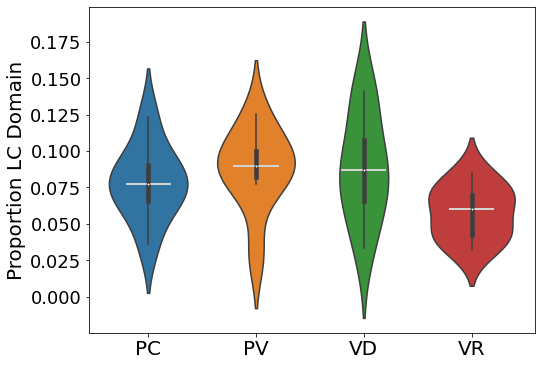

In [369]:
fig, axes = plt.subplots(1,1,figsize = [8, 6])

sns.violinplot(data = data, 
               x = "period", y = "LC")

axes.set_xticklabels(["PC", "PV", "VD", "VR"], fontsize = 20)
axes.set_xlabel("")
axes.set_ylabel("Proportion LC Domain", fontsize = 20)
plt.yticks(fontsize = 18)

medians = []
for k in range(4):
    period = "period" + str(k + 1)
    median = data.query("period == @period")["LC"].median()
    medians.append(median)
    
    sns.lineplot(x = [k - 0.2, k + 0.2], y = median, color = "lightgrey", linewidth = 2)



In [370]:
ttest_ind(data.query("period == 'period4'")["LC"], data.query("period != 'period4'")["LC"])

Ttest_indResult(statistic=-2.44596153739191, pvalue=0.020527418872675954)

p-value < 0.05

The proportion of low-credible domains in period4 is significantly lower than in other periods.